In [82]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join('..')))
sys.path.insert(0, os.path.abspath(os.path.join('../core')))
import numpy as np
import pickle
import numpy as np
from functools import partial
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Lambda, Subtract, Dense
from keras.layers.merge import _Merge
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.datasets import mnist

import train
import costs
from data import predict_with_K_fn
from layer import stack_layers
from util import LearningHandler, make_layer_list, train_gen, get_scale

from sklearn.manifold import TSNE

from scipy.spatial.distance import pdist

%matplotlib inline
import mpld3
mpld3.enable_notebook()

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
def predict_with_K_fn(K_fn, x, bs=1000):
    '''
    Convenience function: evaluates x by K_fn(x), where K_fn is
    a Keras function, by batches of size 1000.
    '''
    if not isinstance(x, list):
        x = [x]
    num_outs = len(K_fn.outputs)
    y = [np.empty((len(x[0]), output_.get_shape()[1])) for output_ in K_fn.outputs]
    recon_means = []
    for i in range(int(x[0].shape[0]/bs + 1)):
        x_batch = []
        for x_ in x:
            x_batch.append(x_[i*bs:(i+1)*bs])
        temp = K_fn(x_batch)
        for j in range(num_outs):
            y[j][i*bs:(i+1)*bs] = temp[j]

    return y

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('paper')
from matplotlib.colors import ListedColormap
# cmap1 = ListedColormap(sns.color_palette().as_hex())
# cmap2 = ListedColormap(sns.color_palette('bright').as_hex())
def plot(x, y=None, x2=None, y2=None, s=10, alpha1=0.5, alpha2=None, label1=None, label2=None, cmap1=None, cmap2=None):
    n = x.shape[1]
    alpha2 = alpha1 if alpha2 is None else alpha2
    if n == 1:
        g = plt.figure()
        plt.scatter(np.zeros((n,)), x[:,1], c=y, s=s, alpha=alpha1, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(np.zeros((n,)), x2[:,1], c=y2, s=s, alpha=alpha2, label=label2, cmap=cmap2)
    if n == 3:
        %matplotlib notebook
        g = plt.figure()
        ax = g.add_subplot(111, projection='3d')
        ax.scatter(x[:,0], x[:,1], x[:,2], c=y, s=s, alpha=alpha1, label=label1)
        if x2 is not None:
            ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=s, alpha=alpha2, label=label2)
    elif n == 784:
        %matplotlib inline
        n_imgs = 10
        # num = 7
        # sub = y == num
        sub = y == y
        for i in range(n_imgs):
            idx = np.random.randint(len(x[sub]))
            if x2 is not None:
                plt.subplot(1,2,1)
                plt.imshow(x2[sub][idx].reshape(28, 28))
            plt.subplot(1,2,2)
            plt.imshow(x[sub][idx].reshape(28, 28))
            g = plt.figure()
    else:
        g = plt.figure()
        plt.scatter(x[:,0], x[:,1], c=y, s=s, alpha=alpha1, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(x2[:,0], x2[:,1], c=y2, s=s, alpha=alpha2, label=label2, cmap=cmap2)
            
    if label1 is not None or label2 is not None:
        plt.legend()
        
    return g

In [4]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# def plot(x, y=None, x2=None, y2=None, s=20, alpha=0.5):
#     if len(x.shape) < 2:
#         x = np.expand_dims(x, axis=-1)
#     d = x.shape[1]
#     n = x.shape[0]
    
#     # create dummy labels if unlabeled
#     if y is None:
#         y = np.zeros(len(x))
#     if y2 is None:
#         y2 = np.ones(len(x2))
        
#     # concatenate to create single vector
#     if x2 is not None:
#             x = np.concatenate([x, x2], axis=0)
#             y = np.concatenate([y, y2], axis=0)
#             print('IMPORTANT', x.shape, y.shape)
    
#     if d == 1:
#         g = sns.scatterplot(np.zeros((n,)), x[:,0], hue=y, size=s, hue_norm=(0, np.max(y)), alpha=alpha)
#     elif d == 3:
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         ax.scatter(x[:,0], x[:,1], x[:,2], c=y, marker='o')
#         if x2 is not None:
#             ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=10)
#     elif d == 784:
#         %matplotlib inline
#         n_imgs = 10
#         # num = 7
#         # sub = y == num
#         sub = y == y
#         for i in range(n_imgs):
#             idx = np.random.randint(len(x[sub]))
#             if x2 is not None:
#                 plt.subplot(1,2,1)
#                 plt.imshow(x2[sub][idx].reshape(28, 28))
#             plt.subplot(1,2,2)
#             plt.imshow(x[sub][idx].reshape(28, 28))
#             plt.figure()
#     else:
        
#         g = sns.scatterplot(x[:,0], x[:,1], hue=y, s=s, hue_norm=(0, np.max(y)), alpha=alpha)
        
# #     g._legend.texts[0].set_text('predicted')
# #     g._legend.texts[0].set_text('actual')
    
#     return g

In [5]:
def generate_loop(n=1200, train_set_fraction=.8):
    t = np.linspace(0, 2*np.pi, num=n)
    
    # generate all three coordinates
    x = np.empty((n, 3))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(2*t)
    x[:,2] = np.sin(3*t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_circle(n=200, train_set_fraction=.8, alpha=4):
#     t = np.linspace(0, 2*np.pi, num=n)
    t = np.log(np.linspace(1, alpha, num=n))
    t = t / np.max(t) * 2 * np.pi
    
    # generate all three coordinates
    x = np.empty((n, 2))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_line(n=1200, train_set_fraction=.8):
    pts_per_cluster = int(n / 2)
    x1 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x2 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x = np.concatenate([x1, x2], axis=1)
    
    # generate labels
#     y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)
    y = x1
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_gaussians(n=1200, n_clusters=2, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / n_clusters)
    r = 1
    
    clusters = []
    
    for x in np.linspace(0, 1, num=n_clusters):
        clusters.append(np.random.normal(x, noise_sigma, size=(pts_per_cluster, 2)))

    # combine clusters
    x = np.concatenate(clusters, axis=0)
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_cc(n=1200, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / 2)
    r = 1

    # generate clusters
    theta1 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)
    theta2 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)

    cluster1 = np.concatenate((np.cos(theta1) * r, np.sin(theta1) * r), axis=1)
    cluster2 = np.concatenate((np.cos(theta2) * r, np.sin(theta2) * r), axis=1)

    # shift and reverse cluster 2
    cluster2[:, 0] = -cluster2[:, 0] + 0.5
    cluster2[:, 1] = -cluster2[:, 1] - 1

    # combine clusters
    x = np.concatenate((cluster1, cluster2), axis=0)

    # add noise to x
    x = x + np.random.randn(x.shape[0], 2) * noise_sigma
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

In [58]:
dataset = 'loop'

if dataset == 'mnist':
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255
    latent_dim = 10
elif dataset == 'gaussians':
    (x_train, y_train), (x_test, y_test) = generate_gaussians(n=2000, n_clusters=1, train_set_fraction=0.85)
    latent_dim = 6
elif dataset == 'line':
    (x_train, y_train), (x_test, y_test) = generate_line(n=2000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=1000, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'cc':
    (x_train, y_train), (x_test, y_test) = generate_cc(n=2000, noise_sigma=0.1, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'circle':
    (x_train, y_train), (x_test, y_test) = generate_circle(n=256, train_set_fraction=0.85, alpha=30)
    latent_dim = 3

x_all = np.concatenate([x_train, x_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)
    
# normalize to between -1 and 1
if dataset != 'mnist':
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b
print('IMPORTANT: max {}, min {}'.format(np.max(x_train), np.min(x_train)))

arch = [
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 512},
    {'type': 'linear', 'size': 16},
    ]

IMPORTANT: max 1.0, min -1.0


In [7]:
# class SpectralNet:
#     def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
#             n_clusters, affinity, scale_nbr, n_nbrs, batch_sizes,
#             siamese_net=None, x_train=None, have_labeled=False):
#         self.y_true = y_true
#         self.y_train_labeled_onehot = y_train_labeled_onehot
#         self.inputs = inputs
#         self.batch_sizes = batch_sizes
#         # generate layers
#         self.layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
#         self.layers += [
#                   {'type': 'tanh',
#                    'size': n_clusters,
#                    'l2_reg': spec_reg,
#                    'name': 'spectral_{}'.format(len(arch)-1)},
#                   {'type': 'Orthonorm', 'name':'orthonorm'}
#                   ]

#         # create spectralnet
#         self.outputs = stack_layers(self.inputs, self.layers)
#         self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.outputs['Unlabeled'])

#         # DEFINE LOSS

#         # generate affinity matrix W according to params
#         if affinity == 'siamese':
#             input_affinity = tf.concat([siamese_net.outputs['A'], siamese_net.outputs['Labeled']], axis=0)
#             x_affinity = siamese_net.predict(x_train, batch_sizes)
#         elif affinity in ['knn', 'full']:
#             input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
#             x_affinity = x_train

#         # calculate scale for affinity matrix
#         scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

#         # create affinity matrix
#         if affinity == 'full':
#             W = costs.full_affinity(input_affinity, scale=scale)
#         elif affinity in ['knn', 'siamese']:
#             W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

#         # if we have labels, use them
#         if have_labeled:
#             # get true affinities (from labeled data)
#             W_true = tf.cast(tf.equal(costs.squared_distance(y_true), 0),dtype='float32')

#             # replace lower right corner of W with W_true
#             unlabeled_end = tf.shape(self.inputs['Unlabeled'])[0]
#             W_u = W[:unlabeled_end, :]                  # upper half
#             W_ll = W[unlabeled_end:, :unlabeled_end]    # lower left
#             W_l = tf.concat((W_ll, W_true), axis=1)      # lower half
#             W = tf.concat((W_u, W_l), axis=0)

#             # create pairwise batch distance matrix self.Dy
#             self.Dy = costs.squared_distance(tf.concat([self.outputs['Unlabeled'], self.outputs['Labeled']], axis=0))
#         else:
#             self.Dy = costs.squared_distance(self.outputs['Unlabeled'])

#         # define loss
#         self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled'])

#         # create the train step update
#         self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
#         self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
# #         self.train_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)

#         # initialize spectralnet variables
#         K.get_session().run(tf.variables_initializer(self.net.trainable_weights))

#     def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
#             lr, drop, patience, num_epochs):
#         # create handler for early stopping and learning rate scheduling
#         self.lh = LearningHandler(
#                 lr=lr,
#                 drop=drop,
#                 lr_tensor=self.learning_rate,
#                 patience=patience)

#         losses = np.empty((num_epochs,))
#         val_losses = np.empty((num_epochs,))

#         # begin spectralnet training loop
#         self.lh.on_train_begin()
#         i = 0
#         for i in range(num_epochs):
#             # train spectralnet
#             losses[i] = train.train_step(
#                     return_var=[self.loss],
#                     updates=self.net.updates + [self.train_step],
#                     x_unlabeled=x_train_unlabeled,
#                     inputs=self.inputs,
#                     y_true=self.y_true,
#                     batch_sizes=self.batch_sizes,
#                     x_labeled=x_train_labeled,
#                     y_labeled=self.y_train_labeled_onehot,
#                     batches_per_epoch=100)[0]

#             # get validation loss
#             val_losses[i] = train.predict_sum(
#                     self.loss,
#                     x_unlabeled=x_val_unlabeled,
#                     inputs=self.inputs,
#                     y_true=self.y_true,
#                     x_labeled=x_train_unlabeled[0:0],
#                     y_labeled=self.y_train_labeled_onehot,
#                     batch_sizes=self.batch_sizes)

#             # do early stopping if necessary
#             if self.lh.on_epoch_end(i, val_losses[i]):
#                 print('STOPPING EARLY')
#                 break

#             # print training status
#             print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

#         return losses[:i+1], val_losses[:i+1]

#     def predict(self, x):
#         # test inputs do not require the 'Labeled' input
#         inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm']}
#         return train.predict(
#                     self.outputs['Unlabeled'],
#                     x_unlabeled=x,
#                     inputs=inputs_test,
#                     y_true=self.y_true,
#                     x_labeled=x[0:0],
#                     y_labeled=self.y_train_labeled_onehot[0:0],
#                     batch_sizes=self.batch_sizes)
class SpectralNet:
    def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
            n_clusters, affinity, scale_nbr, n_nbrs, batch_sizes, normalized=False,
            siamese_net=None, x_train=None, have_labeled=False):
        self.y_true = y_true
        self.y_train_labeled_onehot = y_train_labeled_onehot
        self.inputs = inputs
        self.batch_sizes = batch_sizes
        self.normalized = normalized
        # generate layers
        self.layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
        self.layers += [
                  {'type': 'tanh',
                   'size': n_clusters,
                   'l2_reg': spec_reg,
                   'name': 'spectral_{}'.format(len(arch)-1)},
                  {'type': 'Orthonorm', 'name':'orthonorm'}
                  ]

        # create spectralnet
        self.outputs = stack_layers(self.inputs, self.layers)
        self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.outputs['Unlabeled'])

        # DEFINE LOSS

        # generate affinity matrix W according to params
        if affinity == 'siamese':
            input_affinity = tf.concat([siamese_net.outputs['A'], siamese_net.outputs['Labeled']], axis=0)
            x_affinity = siamese_net.predict(x_train, batch_sizes)
        elif affinity in ['knn', 'full']:
            input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
            x_affinity = x_train

        # calculate scale for affinity matrix
        scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

        # create affinity matrix
        if affinity == 'full':
            W = costs.full_affinity(input_affinity, scale=scale)
        elif affinity in ['knn', 'siamese']:
            W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

        # if we have labels, use them
        if have_labeled:
            # get true affinities (from labeled data)
            W_true = tf.cast(tf.equal(costs.squared_distance(y_true), 0),dtype='float32')

            # replace lower right corner of W with W_true
            unlabeled_end = tf.shape(self.inputs['Unlabeled'])[0]
            W_u = W[:unlabeled_end, :]                  # upper half
            W_ll = W[unlabeled_end:, :unlabeled_end]    # lower left
            W_l = tf.concat((W_ll, W_true), axis=1)      # lower half
            W = tf.concat((W_u, W_l), axis=0)

            # create pairwise batch distance matrix self.Dy
            y_ = tf.concat([self.outputs['Unlabeled'], self.outputs['Labeled']], axis=0)
        else:
            y_ = self.outputs['Unlabeled']
            
        if self.normalized:
            y_old = y_
            y_ = y_ / tf.expand_dims(tf.reduce_sum(W, axis=1), axis=-1)
        
        self.Dy = costs.squared_distance(y_)

        # define loss
        self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled'])

        # create the train step update
        self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
        self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
#         self.train_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
        
        # initialize spectralnet variables
        K.get_session().run(tf.variables_initializer(self.net.trainable_weights))

    def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
            lr, drop, patience, num_epochs):
        # create handler for early stopping and learning rate scheduling
        self.lh = LearningHandler(
                lr=lr,
                drop=drop,
                lr_tensor=self.learning_rate,
                patience=patience)

        losses = np.empty((num_epochs,))
        val_losses = np.empty((num_epochs,))

        # begin spectralnet training loop
        self.lh.on_train_begin()
        i = 0
        for i in range(num_epochs):
            # train spectralnet
            losses[i] = train.train_step(
                    return_var=[self.loss],
                    updates=self.net.updates + [self.train_step],
                    x_unlabeled=x_train_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    batch_sizes=self.batch_sizes,
                    x_labeled=x_train_labeled,
                    y_labeled=self.y_train_labeled_onehot,
                    batches_per_epoch=100)[0]

            # get validation loss
            val_losses[i] = train.predict_sum(
                    self.loss,
                    x_unlabeled=x_val_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    x_labeled=x_train_unlabeled[0:0],
                    y_labeled=self.y_train_labeled_onehot,
                    batch_sizes=self.batch_sizes)

            # do early stopping if necessary
            if self.lh.on_epoch_end(i, val_losses[i]):
                print('STOPPING EARLY')
                break

            # print training status
            print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

        return losses[:i+1], val_losses[:i+1]
    
    def predict(self, x):
        # test inputs do not require the 'Labeled' input
        inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm']}
        return train.predict(
                    self.outputs['Unlabeled'],
                    x_unlabeled=x,
                    inputs=inputs_test,
                    y_true=self.y_true,
                    x_labeled=x[0:0],
                    y_labeled=self.y_train_labeled_onehot[0:0],
                    batch_sizes=self.batch_sizes)

In [8]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class SVG:
    def __init__(self, inputs, spectralnet, orig_dim, latent_dim=2):
        from keras.layers import Input, Dense
        optimizer = 'adam' #RMSprop(lr=0.00005)
        self.input = inputs['Unlabeled']
        self.orig_dim = orig_dim
        
        # initialize losses:
        self.gen_loss = []
        self.disc_loss = []
        self.vae_loss = []
        
        if spectralnet is not None:
            x = self.copy_spectralnet(spectralnet)
        else:
            self.latent_dim = latent_dim
            x = self.input

        # create encoder
        x_enc = self.build_encoder(x, generate_mu=(spectralnet is None))
        self.encoder = Model(inputs=self.input, outputs=x_enc)

        # create decoder
        x_recon = self.build_decoder(x_enc)
        self.decoder = Model(inputs=self.input, outputs=x_recon)
        self.x_recon = x_recon
        
        # create critic
        x_critic, x_critic_interm, x_critic_input = self.build_critic(input_shape=(orig_dim,))
        self.critic, self.critic_interm = Model(x_critic_input, x_critic), Model(x_critic_input, x_critic_interm)
        
        ######################################
        #                                        
        # build computation graph for critic
        #                                        
        ######################################
        self.encoder.trainable = False
        self.decoder.trainable = False
        self.critic.trainable = True
        
        # fake example
        fake_sample = x_recon
        
        fake = self.critic(fake_sample)
        valid = self.critic(self.input)
        
        # construct weighted average between real and fake images
        interpolated_sample = RandomWeightedAverage()([self.input, fake_sample])
        # determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_sample)

        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_sample)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=self.input,
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        
        #######################################
        #                                        
        # build computation graph for generator
        #                                        
        #######################################

        # For the generator we freeze the critic's layers
        self.encoder.trainable = False
        self.decoder.trainable = True
        self.critic.trainable = False

        # Discriminator determines validity
        valid = self.critic(x_recon)
        # Defines generator model
        self.generator_model = Model(self.input, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)

        #######################################
        #                                        
        # build computation graph for VAE
        #                                        
        #######################################
        
        # For the VAE we freeze the critic's layers
        self.encoder.trainable = True
        self.decoder.trainable = True
        self.critic.trainable = False
        
#         x_interm = self.critic_interm(x_recon)
#         x_interm_orig = self.critic_interm(self.input)
        x_interm = x_recon
        x_interm_orig = self.input
        
        from keras.losses import mse
        def vae_loss(_, __):
            # alpha is what we want the variances to be (usually 1, but we want it smaller)
            alpha = 1
            alpha = float(alpha)
#             alpha = K.sum((self.mu - K.mean(self.mu, axis=0))**2)
            reconstruction_loss = K.sum(mse(x_interm, x_interm_orig), axis=-1) * self.orig_dim
            kl_loss = -1 + K.log(alpha) - self.sigma + K.exp(self.sigma)/alpha
            kl_loss = K.sum(kl_loss, axis=-1) * 0.5
            vae_loss = K.mean(reconstruction_loss + kl_loss)
            return vae_loss
        
        self.vae = Model(inputs=self.input, outputs=x_interm)
        self.vae.compile(optimizer=optimizer, loss=vae_loss)
        
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)
        
    def build_critic(self, input_shape):
        x = x_input = Input(shape=input_shape)
        x = Dense(256, input_shape=input_shape, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = x_interm = Dense(32, name='interm_layer', activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        
        return x, x_interm, x_input
        
    def build_decoder(self, x):
        x = Dense(1024, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        # last layer of decoder / generator is always tanh (LINEAR because of WASSERSTEIN LOSS)
        x = Dense(self.orig_dim, activation='linear')(x)
        
        return x
        
    def build_encoder(self, x_input, generate_mu=False):
        if generate_mu:
            print("GENERATING MU")
        x_enc = Dense(256, activation='relu')(x_input)
        x_enc = Dense(256, activation='relu')(x_enc)
        x_enc = Dense(1024, activation='relu')(x_enc)

        # option 1
        self.sigma = sigma = Dense(self.latent_dim, activation='linear')(x_enc)
        self.mu = mu = x_input
        self.x_enc = Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([mu, sigma])
        self.encoder = Model(self.input, [self.x_enc])
        
        return self.x_enc
        
    def copy_spectralnet(self, spectralnet):
        xs = [self.input]
        layers = []
        for l in spectralnet.net.layers[1:-1]:
            w = l.get_weights()
            n, m = w[0].shape
            if hasattr(l, 'activation'):
                act = l.activation
            new_l = Dense(m, activation=act, input_shape=(n,), weights=w)
            new_l.trainable = False
            xs.append(new_l(xs[-1]))
            layers.append(new_l)

        pre_x = xs[-1]
        # add orthonorm layer
        sess = K.get_session()
        with tf.variable_scope('', reuse=True):
            v = tf.get_variable("ortho_weights_store")
        ows = sess.run(v)
        t_ows = K.variable(ows)
        l = Lambda(lambda x: K.dot(x, t_ows))
        l.trainable = False
        xs.append(l(xs[-1]))
        layers.append(l)

        x = xs[-1]

        self.sn = Model(inputs=self.input, outputs=x)

        self.latent_dim = int(x.get_shape()[1])
        if self.latent_dim != latent_dim:
            print("""warning, spectralnet's latent_dim={} 
            and provided latent_dim={} do not match, 
            defaulting to spectralnet's!""".format(self.latent_dim, latent_dim))
            
        return x

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output

    def generate_from_samples(self, x, return_mu_sigma=False):
        get_fn = K.function([self.input], [self.x_recon, self.mu, self.sigma])
        x_recon, x_mu, x_sigma = predict_with_K_fn(get_fn, x)
        if return_mu_sigma:
            return x_recon, x_mu, x_sigma
        else:
            return x_recon

    def train(self, xy_train, xy_val, epochs=1, batch_size=128, patience=5):
        x_train, y_train = xy_train
        x_val, y_val = xy_val
        earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
        val_data = list((x_val, x_val))

        self.vae.fit(x=x_train,
                y=x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=val_data,
                # callbacks=[earlystop, pe],
                callbacks=[earlystop],
                verbose=2)
        
    def train_gan(self, X_train, batch_size=128, epochs=10, n_critic=5, n_vae=5, sample_interval=1):
        # Adversarial ground truths
            valid = -np.ones((batch_size, 1))
            fake =  np.ones((batch_size, 1))
            dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
            d_loss = g_loss = vae_loss = 0
            for epoch in range(epochs):

#                 for _ in range(n_critic):

#                     # ---------------------
#                     #  Train Discriminator
#                     # ---------------------

#                     # Select a random batch of samples
#                     idx = np.random.randint(0, X_train.shape[0], batch_size)
#                     samples = X_train[idx]
#                     # Train the critic
#                     d_loss = self.critic_model.train_on_batch(samples,
#                                                                     [valid, fake, dummy])
#                     self.disc_loss.append(d_loss)
                    
#                 # ---------------------
#                 #  Train Generator
#                 # ---------------------
#                 idx = np.random.randint(0, X_train.shape[0], batch_size)
#                 samples = X_train[idx]
#                 g_loss = self.generator_model.train_on_batch(samples, valid)
#                 self.gen_loss.append(g_loss)
                
                
                #######################
                #
                # Train VAE
                #
                #######################
                
                for _ in range(n_vae):

                    # ---------------------
                    #  Train Discriminator
                    # ---------------------

                    # Select a random batch of samples
                    idx = np.random.randint(0, X_train.shape[0], batch_size)
                    samples = X_train[idx]
                    vae_loss = self.vae.train_on_batch(samples, samples)
                    self.vae_loss.append(vae_loss)

                # Plot the progress
                print ("{} [D loss: {}] [G loss: {}] [VAE loss: {}]".format(epoch, d_loss, g_loss, vae_loss))
                
    def generate(self, num_gen=10):
        noise = np.random.normal(0, 1, (num_gen, self.latent_dim))
        return self.decoder.predict(noise)
        

<IPython.core.display.Javascript object>


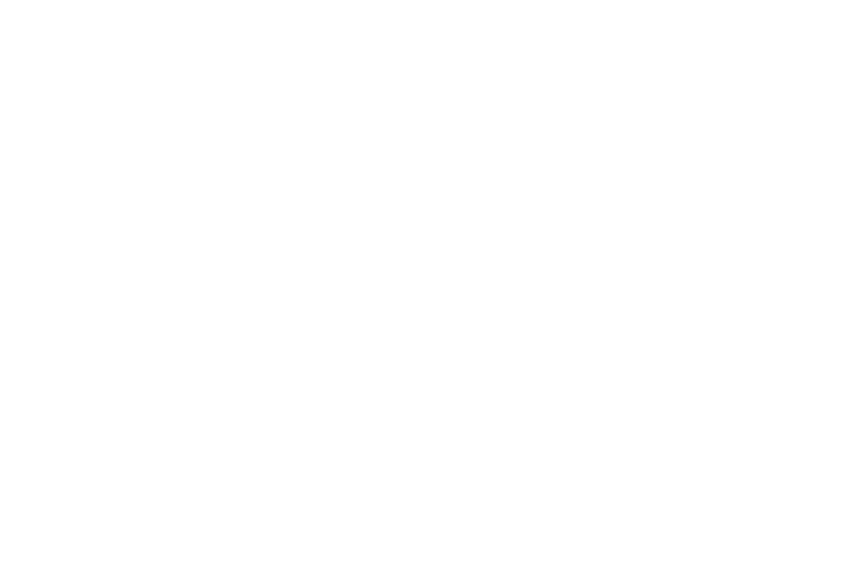

In [9]:
split = int(len(x_train)*0.8)
x_train, x_val = x_train[:split], x_train[split:]
y_train, y_val = y_train[:split], y_train[split:]

# plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
g = plot(x_train, y_train)

In [10]:
n_clusters = latent_dim

bsize = 32

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape,name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape,name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape,name='OrthonormInput'),
    }
k = 2
spectral_net = SpectralNet(inputs, arch,
            None, y_true, y_train_labeled_onehot,
            n_clusters, affinity='full', scale_nbr=k, n_nbrs=k, 
            batch_sizes=batch_sizes, siamese_net=None, 
            x_train=x_train, have_labeled=len(x_train))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
spectral_net.train(
        x_train, np.zeros_like(x_train[0:0]), x_test,
        lr=5e-5, drop=0.1, patience=30, num_epochs=100)

Epoch: 0, loss=4.710082, val_loss=0.182406
Epoch: 1, loss=1.206063, val_loss=0.040914
Epoch: 2, loss=0.384989, val_loss=0.025276
Epoch: 3, loss=0.292791, val_loss=0.022744
Epoch: 4, loss=0.267948, val_loss=0.035368
Epoch: 5, loss=0.293122, val_loss=0.015064
Epoch: 6, loss=0.288703, val_loss=0.019128
Epoch: 7, loss=0.230471, val_loss=0.018549
Epoch: 8, loss=0.200937, val_loss=0.013880
Epoch: 9, loss=0.134761, val_loss=0.012510
Epoch: 10, loss=0.134080, val_loss=0.011376
Epoch: 11, loss=0.147100, val_loss=0.012351
Epoch: 12, loss=0.130733, val_loss=0.013172
Epoch: 13, loss=0.136506, val_loss=0.013929
Epoch: 14, loss=0.126581, val_loss=0.014104
Epoch: 15, loss=0.138767, val_loss=0.012735
Epoch: 16, loss=0.124742, val_loss=0.011714
Epoch: 17, loss=0.133814, val_loss=0.011932
Epoch: 18, loss=0.127365, val_loss=0.012879
Epoch: 19, loss=0.126919, val_loss=0.012343
Epoch: 20, loss=0.128131, val_loss=0.012830
Epoch: 21, loss=0.135022, val_loss=0.013111
Epoch: 22, loss=0.129001, val_loss=0.01336

(array([4.7100821 , 1.20606268, 0.3849892 , 0.29279057, 0.26794763,
        0.29312199, 0.28870316, 0.23047136, 0.20093713, 0.13476145,
        0.13408035, 0.14710012, 0.13073327, 0.13650582, 0.12658138,
        0.13876731, 0.1247424 , 0.1338142 , 0.12736528, 0.12691917,
        0.12813106, 0.13502235, 0.12900136, 0.13180796, 0.1225984 ,
        0.13379582, 0.11503021, 0.13143172, 0.13491018, 0.13326193,
        0.13358045, 0.11431423, 0.12548377, 0.13465017, 0.14391587,
        0.13382913, 0.13429922, 0.12536359, 0.13534806, 0.13381537,
        0.126179  , 0.12247329, 0.13168197, 0.12606744, 0.1270146 ,
        0.12372616, 0.12605928, 0.12940162, 0.11902655, 0.13996853,
        0.12339882, 0.12227435, 0.12894601, 0.13143685, 0.12709115,
        0.12290003, 0.12766243, 0.13477271, 0.11452269, 0.12130212,
        0.13778402, 0.116097  , 0.13379256, 0.1275368 , 0.13019751,
        0.12331709, 0.12913474, 0.12913099, 0.12410147, 0.12273597,
        0.12400442, 0.12474861, 0.11786936, 0.12

<IPython.core.display.Javascript object>


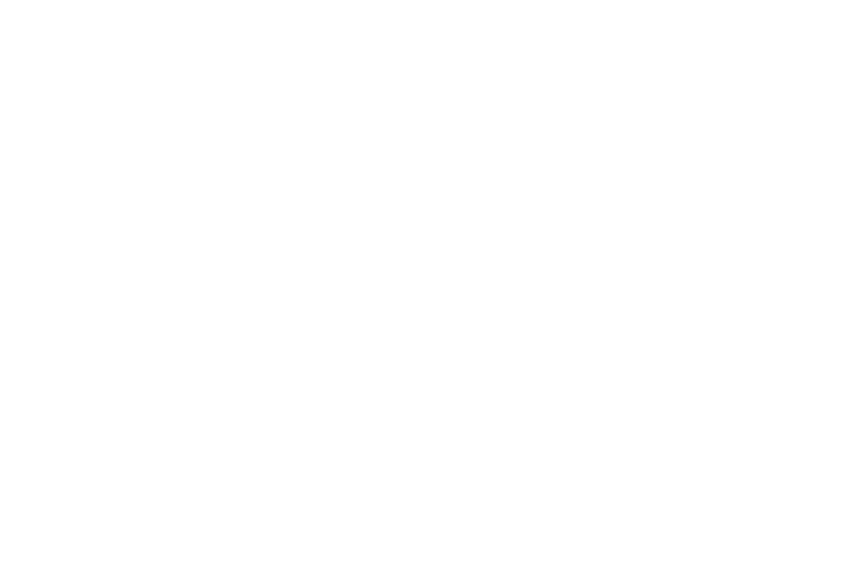

range of y_pred values: 1.2416807413101196 - -1.724015474319458


In [12]:
y_pred = spectral_net.predict(x_test)
g = plot(y_pred[:,:3], y_test)
print('range of y_pred values: {} - {}'.format(np.max(y_pred), np.min(y_pred)))

<IPython.core.display.Javascript object>


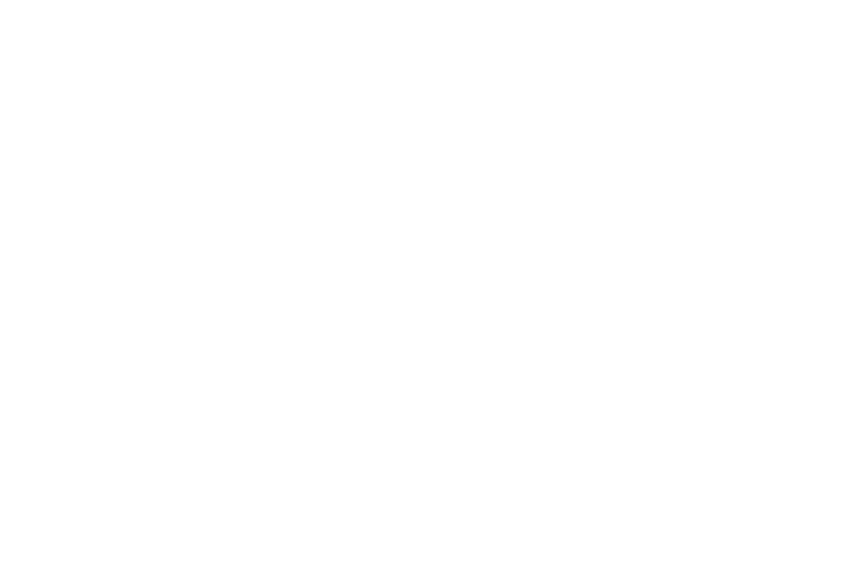

In [13]:
# # now plot all the dimensions of spectralnet
y_pred_embedded = TSNE().fit_transform(y_pred)
g = plot(y_pred_embedded[:,:2], y=y_test)

In [14]:
svg = SVG(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[-1], latent_dim=latent_dim)

In [15]:
svg.train_gan(x_train, epochs=100, n_critic=10, n_vae=50)

0 [D loss: 0] [G loss: 0] [VAE loss: 11.371416091918945]
1 [D loss: 0] [G loss: 0] [VAE loss: 9.196512222290039]
2 [D loss: 0] [G loss: 0] [VAE loss: 8.696724891662598]
3 [D loss: 0] [G loss: 0] [VAE loss: 8.686330795288086]
4 [D loss: 0] [G loss: 0] [VAE loss: 8.803727149963379]
5 [D loss: 0] [G loss: 0] [VAE loss: 8.032028198242188]
6 [D loss: 0] [G loss: 0] [VAE loss: 7.770928382873535]
7 [D loss: 0] [G loss: 0] [VAE loss: 7.533490180969238]
8 [D loss: 0] [G loss: 0] [VAE loss: 7.333669662475586]
9 [D loss: 0] [G loss: 0] [VAE loss: 7.570868015289307]
10 [D loss: 0] [G loss: 0] [VAE loss: 7.955868721008301]
11 [D loss: 0] [G loss: 0] [VAE loss: 7.684815883636475]
12 [D loss: 0] [G loss: 0] [VAE loss: 7.794328212738037]
13 [D loss: 0] [G loss: 0] [VAE loss: 7.428866386413574]
14 [D loss: 0] [G loss: 0] [VAE loss: 8.242854118347168]
15 [D loss: 0] [G loss: 0] [VAE loss: 7.432239532470703]
16 [D loss: 0] [G loss: 0] [VAE loss: 7.8064470291137695]
17 [D loss: 0] [G loss: 0] [VAE loss: 7

In [16]:
%matplotlib

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


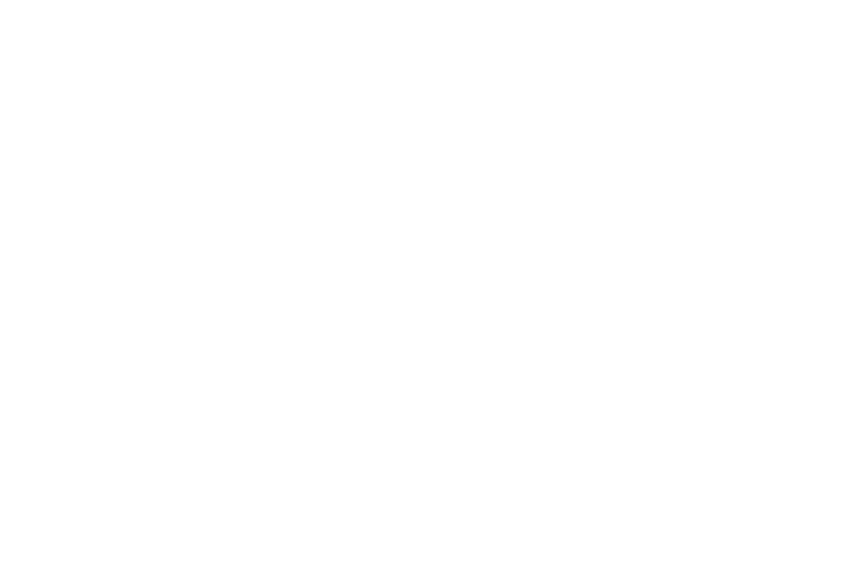

In [17]:
x_gen = svg.generate_from_samples(x_train)
g = plot(x_gen, y_train)

<IPython.core.display.Javascript object>


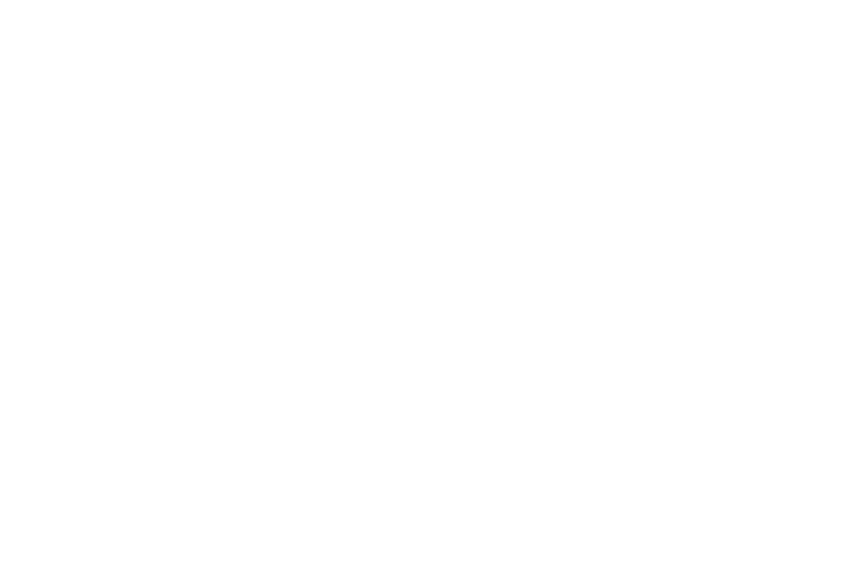

In [18]:
n_samples = 100
n_items = 1
x_gen = np.zeros((n_samples*n_items, x_train.shape[1]))
y_gen = np.zeros((n_samples*n_items,))
step = int(len(x_test) / n_items)
for i in range(n_samples):
    for n in range(n_items):
#         print(n_items*i + n, n*step, step)
        x_gen[n_items*i + n,:] = x_test[n*step,:]
        y_gen[n_items*i + n] = y_test[n*step]
    
x_gen = svg.generate_from_samples(x_gen)
g = plot(x_gen[:, :3], y_gen)

<IPython.core.display.Javascript object>


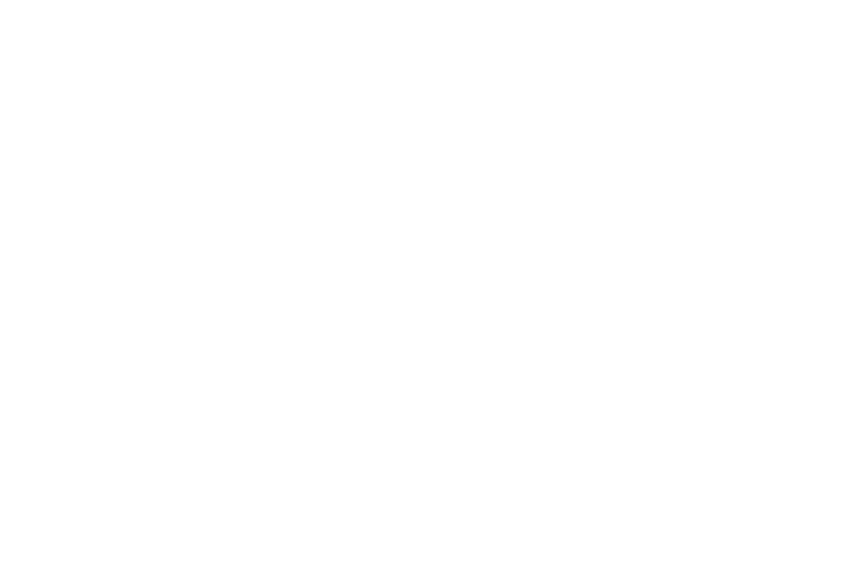

In [19]:
x = svg.generate_from_samples(x_test)
if dataset == 'mnist':
    n_imgs = 10
    # num = 7
    # sub = y_test == num
    sub = y_test == y_test
    for i in range(n_imgs):
        idx = np.random.randint(len(x[sub]))
        plt.subplot(1,2,1)
        plt.imshow(x_test[sub][idx].reshape(28, 28))
        plt.subplot(1,2,2)
        plt.imshow(x[sub][idx].reshape(28, 28))
        plt.figure()
else:
    x = svg.generate_from_samples(x_test)
    plot(x, y_test)

In [20]:
# get number of neighbors within one standard deviation of each element in x_test
get_distr = K.function([svg.input], [svg.sigma, svg.mu])
_sigma, _mu = predict_with_K_fn(get_distr, x_test)
_sigma = np.exp(_sigma)

num_close = []
for i in range(len(_sigma)):
    s, m = _sigma[i,:], _mu[i,:]
    scaled_dists = (_mu - m)/s
    # consider as neighbors all points within the variance of x_i
    less_than_std = np.abs(scaled_dists) < 1
    less_than_std = np.logical_and(less_than_std[:,0], less_than_std[:,1])
    # split neighbors into those of the same class and those of a different class
    same, diff = (y_test[less_than_std] == y_test[i]), (y_test[less_than_std] != y_test[i])
    num_close.append((np.sum(same), np.sum(diff)))

<IPython.core.display.Javascript object>


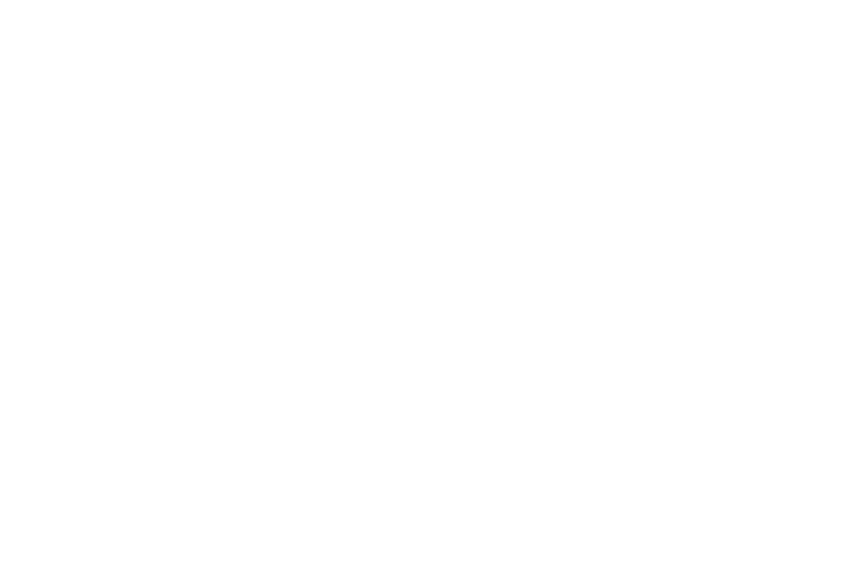

In [21]:
perturbed_x = _mu + _sigma * np.random.normal(size=_mu.shape)
g = plot(perturbed_x[:,:2][y_test.astype(np.bool)], x2=(perturbed_x[:,:2])[(1 - y_test).astype(np.bool)])

In [22]:
# differentiate decoder with respect to inputs to compute another jacobian, and then evaluate it on the same point
_jacobian = [tf.expand_dims(tf.gradients(svg.x_recon[:,i], svg.x_enc)[0], 1) for i in range(svg.x_recon.shape[1])]
jacobian = tf.reduce_sum(tf.concat(_jacobian, axis=1), axis=0)
B = tf.diag(tf.exp(tf.reduce_sum(svg.sigma, axis=0)) ** 2)
cov = tf.matmul(jacobian, tf.matmul(B, jacobian, transpose_b=True))
cov = tf.reshape(cov, (x_test[0].shape[0], x_test[0].shape[0]))

In [23]:
# create burst from a point and compute covariance matrix
burst_size = 1000
rand_idx = np.random.randint(len(x_test))
x_ = x_test[rand_idx]
# x_ = np.array((np.cos(.25), np.sin(.25)))
x_arr = np.array([x_] * burst_size)
x_rec = svg.generate_from_samples(x_arr)

cov_burst = np.cov((x_rec - np.mean(x_rec, axis=0)).T)

# run gradient burst"
# cov_grad = K.get_session().run([svg.x_recon, cov, B, jacobian], feed_dict={svg.input: np.array([x_]*1)})
cov_grad = K.get_session().run([cov], feed_dict={svg.input: np.array([x_]*1)})[0]

In [24]:
cov_burst

array([[4.41253761e-04, 8.15255532e-04, 1.45134356e-04],
       [8.15255532e-04, 1.51008078e-03, 2.70714243e-04],
       [1.45134356e-04, 2.70714243e-04, 6.44564342e-05]])

In [25]:
cov_grad

array([[ 1.9042922e-05,  3.6407859e-05, -2.5124918e-06],
       [ 3.6407859e-05,  6.9609872e-05, -4.8084480e-06],
       [-2.5124918e-06, -4.8084480e-06,  3.4974332e-07]], dtype=float32)

In [26]:
l_burst, _ = np.linalg.eig(cov_burst)
l_grad, _ = np.linalg.eig(cov_grad)
print('l_burst:', l_burst, l_burst/l_burst[0])
print('l_grad:', l_grad, l_grad/l_grad[0])

l_burst: [1.99923441e-03 8.03509840e-07 1.57530623e-05] [1.00000000e+00 4.01908769e-04 7.87954740e-03]
l_grad: [8.8984387e-05 2.1250070e-10 1.7938017e-08] [1.0000000e+00 2.3880673e-06 2.0158612e-04]


<IPython.core.display.Javascript object>


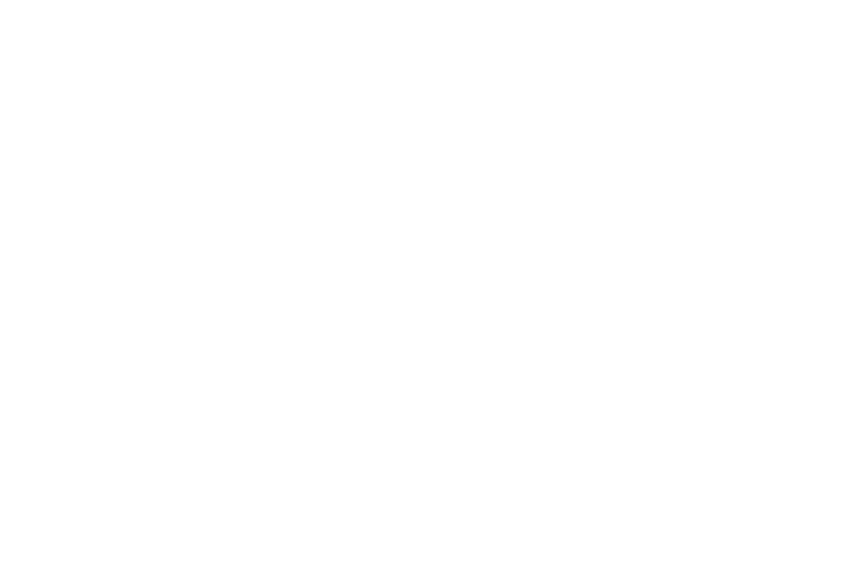

In [27]:
g = plot(x_rec, x2=x_test, label1='true', label2='predicted')

<IPython.core.display.Javascript object>


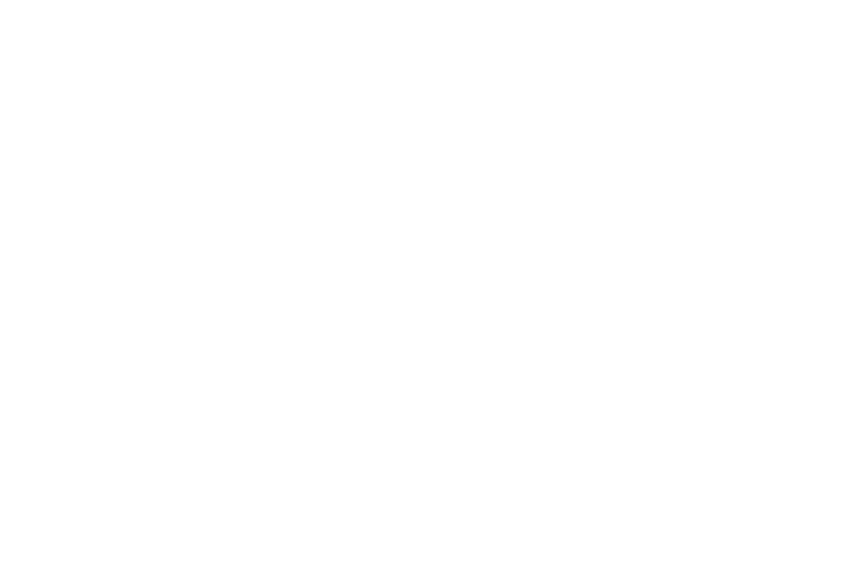

In [28]:
x__ = np.expand_dims(x_, axis=0)
g = plot(x__, x2=x_test, alpha=.1, label1='true', label2='predicted')

<IPython.core.display.Javascript object>


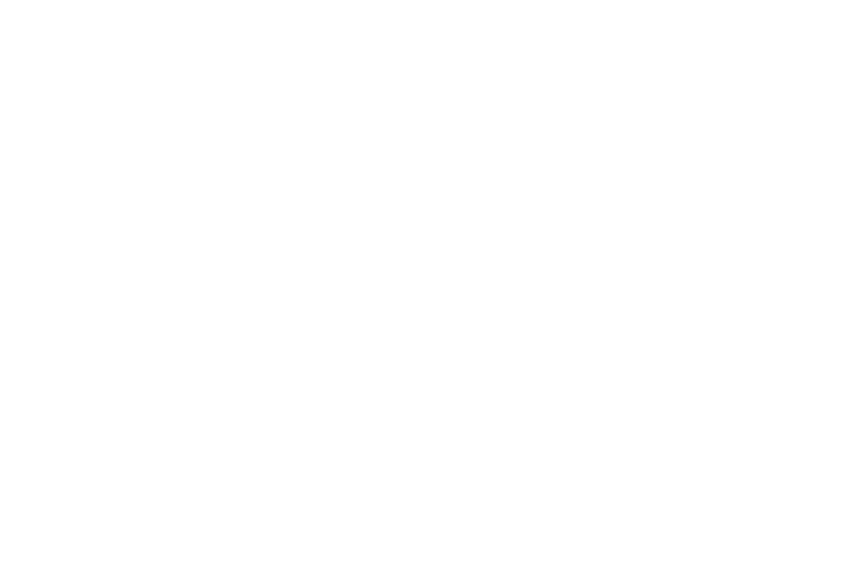

In [29]:
g = plot(x_test)

In [30]:
# RANDOM WALK
def walk(f, x_arr, branch_factor=5, n_steps=20, max_size=1000):
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape([-1, x_.shape[0]])
        (x_arr, x_mu, x_sigma) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:1000]
        x_arr, x_mu, x_sigma = x_arr[p], x_mu[p], x_sigma[p]
        
    return x_arr, x_mu, x_sigma

In [31]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)
y_test_sz = np.mean(f(x_all)[2], axis=1)
print(y_test_sz)
sz_max = np.max(y_test_sz)
sz_min = np.min(y_test_sz)
y_test_sz = (y_test_sz - sz_min)/(sz_max - sz_min) * 5
print(np.min(y_test_sz), np.max(y_test_sz))
y_test_sz = np.exp(y_test_sz)

[-3.49924498 -4.26164837 -4.42565763 -3.75729944 -3.23303214 -5.41440529
 -3.70461818 -2.5172755  -3.8059506  -3.40197573 -3.97274965 -3.62910158
 -4.61064109 -3.53620895 -5.42994401 -5.42474754 -3.74749876 -4.6712467
 -4.5913704  -4.45998324 -2.53726087 -4.03483839 -4.11841362 -3.63843028
 -4.07403648 -3.64285007 -4.11602298 -3.51956584 -2.96655957 -5.37255417
 -5.46831894 -3.36313014 -4.77254702 -2.69140709 -5.16107513 -3.73107053
 -3.50476805 -5.34807637 -3.50531388 -5.34220324 -4.17199716 -4.86291809
 -5.05865643 -2.78349105 -4.16971061 -4.72734685 -3.49722861 -4.52853198
 -4.57721659 -3.87863492 -2.89227215 -4.63396377 -4.18209156 -4.65288719
 -5.38237638 -3.86102948 -4.06524235 -4.12189382 -4.57699598 -4.1649247
 -3.50493926 -3.06731239 -4.8184784  -4.07943246 -3.23424381 -3.83886983
 -3.57292799 -4.58220834 -3.67736288 -3.53641552 -4.26370506 -5.3924852
 -4.10602643 -4.06900798 -2.50540038 -3.83105977 -3.65205651 -3.97164342
 -5.40430177 -3.50216933 -3.07763202 -4.10115306 -4.73

<IPython.core.display.Javascript object>


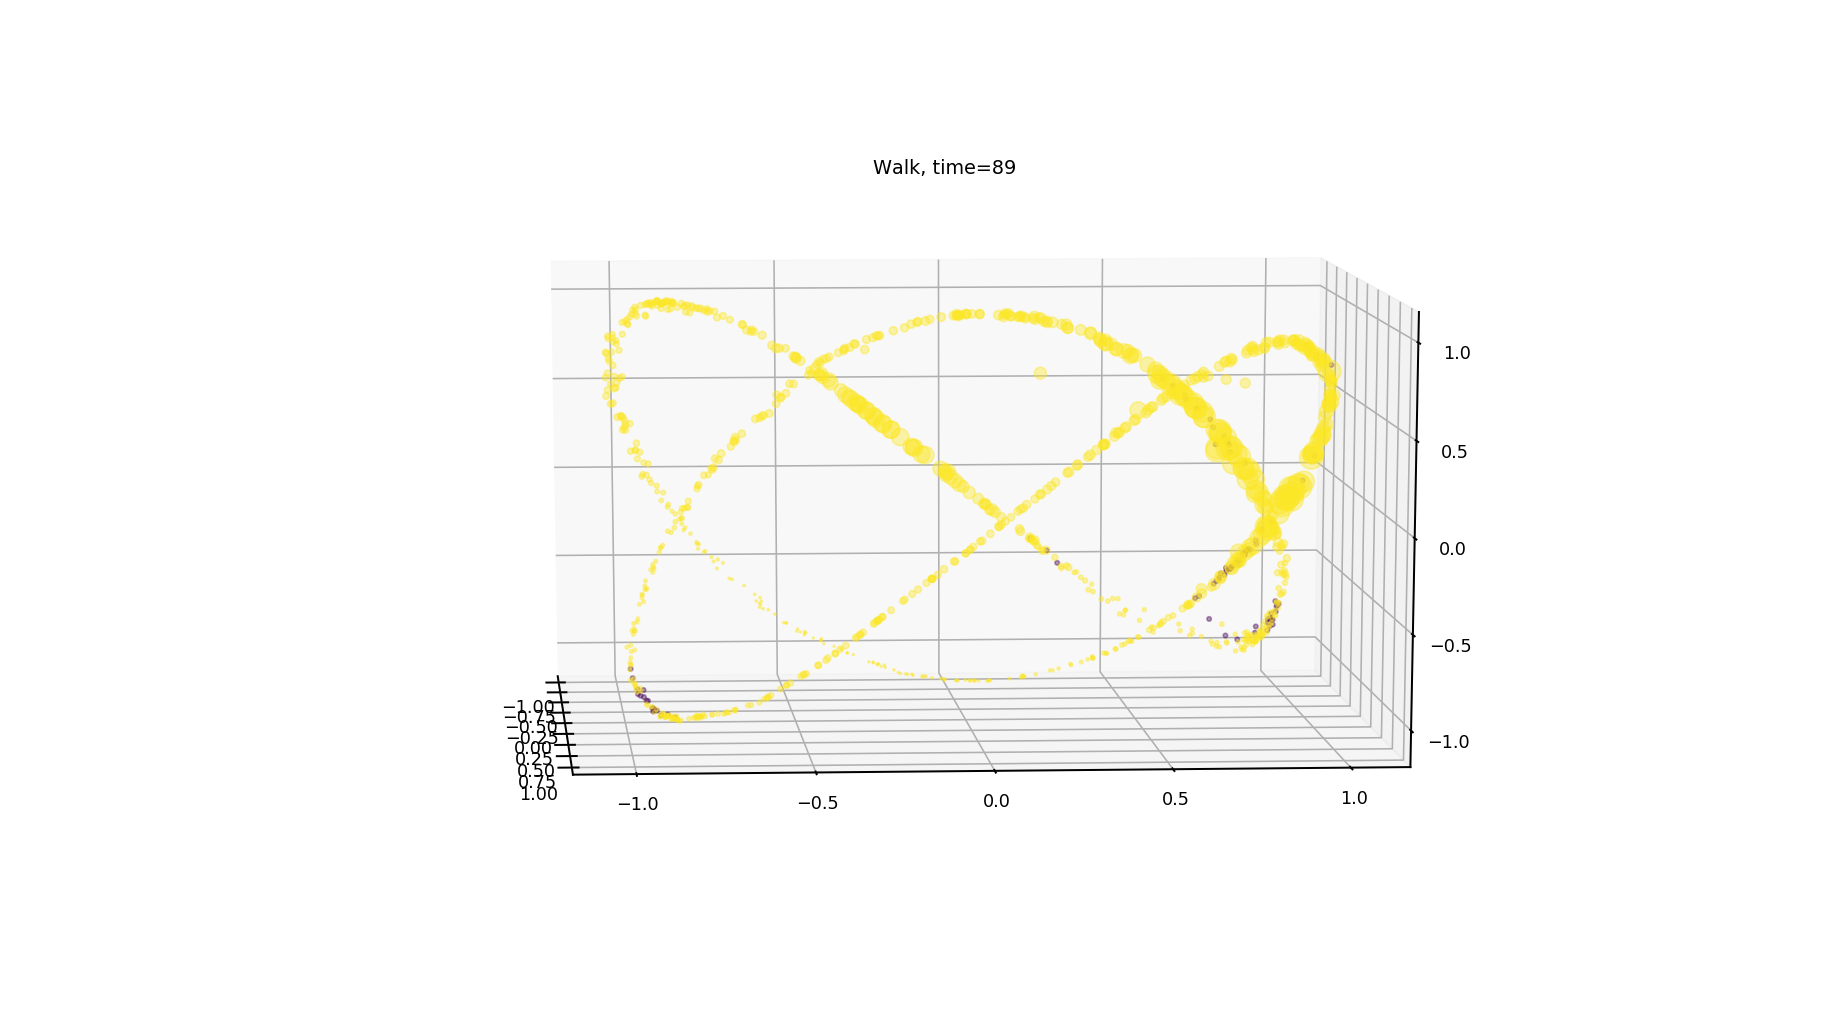

In [35]:
import matplotlib.animation
import pandas as pd
from functools import partial

# which space do we want to plot in?
plot_latent = False
plot_idx = 1 if plot_latent else 0

x_arr = np.random.permutation(x_test)[:100]
x__ = f(x_all)[plot_idx]
x_ = f(x_arr)[plot_idx]
x_tot = np.concatenate([x_, x__], axis=0)
y_tot = np.concatenate([np.zeros(shape=(len(x_arr),)), np.ones(shape=(len(x__),))*2], axis=0)
y_sz = np.concatenate([np.ones(shape=(len(x_arr),))*5, y_test_sz], axis=0)

def update_graph(num):
    global x_arr
    global x__
    global y_tot
    x_arr, x_mu, x_sigma = f(x_arr)
    # plot in latent or original space
    x_ = x_mu if plot_latent else x_arr
    
    x_ = np.concatenate([x_, x__], axis=0)
    graph._offsets3d = (x_[:,0], x_[:,1], x_[:,2])
    ax.view_init(elev=10, azim=num*4)
    title.set_text('Walk, time={}'.format(num))

fig = plt.figure(figsize=(12.8, 7.2))
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Walk, time=0')

graph = ax.scatter(x_tot[:,0], x_tot[:,1], x_tot[:,2], c=y_tot, s=y_sz, alpha=0.4)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 90, 
                               interval=400, blit=False)

In [33]:
from IPython.display import HTML
HTML(ani.to_html5_video(embed_limit=None))

In [83]:
# TEST BILIP CONDITION
k_nbrs = 5
n_draws = 10
from annoy import AnnoyIndex
t = AnnoyIndex(x_all.shape[1])

K1s = []
K2s = []

x_shuffled = np.random.permutation(x_all)
# p = np.argsort(y_all)
# x_shuffled = x_all[p]
# y_shuffled = y_all[p]
for i, x_i in enumerate(x_shuffled):
    t.add_item(i, x_i)
    
t.build(10)
for i, x_i in enumerate(x_shuffled):
    a = t.get_nns_by_item(i, k_nbrs)
    nbrs = x_shuffled[a]
    A = np.cov(nbrs.T) * 50
    # generate a gaussian from the covariance (TEST)
    # d = x_i + np.random.normal(size=(n_draws, x_all.shape[1])).dot(A)
    d_latent = pdist(f(nbrs)[1])
    d_orig = pdist(nbrs)
    K1s.append(np.max(d_latent/d_orig))
    K2s.append(np.max(d_latent/d_orig))
# g = plot(d, x2=x_shuffled, alpha1=1, alpha2=.1)

In [85]:
np.min(K1s

[1.1335251256241925,
 1.0872441828315758,
 0.2127158156346352,
 0.9689434819487739,
 0.42648575085597085,
 0.5704333769336656,
 1.3661447416596124,
 0.2587754187179202,
 0.2605850690714837,
 0.12776634462827877,
 0.17356053613543962,
 0.3076686133121888,
 0.38942129105286216,
 0.31056931650413977,
 0.29656936224128694,
 0.13148759884230324,
 0.30458735936580167,
 0.45415926819606395,
 0.4868684658814196,
 0.5636330254375002,
 0.7796351356152638,
 0.334930913167566,
 0.4293160128939759,
 0.8625642021259226,
 0.3743005025249875,
 0.09299515532718286,
 1.0050913826664656,
 0.39889726684369575,
 0.4359170429477878,
 0.13716252890122566,
 1.18976566292055,
 0.7391759404160723,
 0.13837083675386339,
 0.28920096052657923,
 1.1680160493645184,
 0.1913360467918923,
 0.11020522853395656,
 0.40138771117507704,
 0.4128659764639598,
 1.3129269186662995,
 0.48862396352885773,
 0.19910673873233317,
 0.7166137193837124,
 0.15889039592542933,
 0.532759081651102,
 0.12671731012621404,
 0.128341999732823

In [34]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)

x_test_sample = np.random.permutation(x_test)[:10]
x_arr, x_sigma, x_mu = walk(f, x_test_sample)

ValueError: cannot reshape array of size 150 into shape (100)

In [ ]:
g = plot(x_arr, x2=x_test, label1='predicted', label2='true')

In [ ]:
# g = plot(x_mu, x2=f(x_test_sample)[1])
g = plot(x_mu, x2=f(x_test)[1])

In [ ]:
g = plot(x_arr)